# 1.IMPORT LIBRARIES

In [7]:
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import cross_val_score,train_test_split
import xgboost as xgb

In [3]:
warnings.filterwarnings('ignore')

# 2.TRAIN MODEL

In [4]:
# READ DEG.CSV
X=pd.read_csv('results/normalized_data_up_genes.csv',
              index_col=0)
X=X[~X.index.isnull()]
X=X.T
X.sort_index(inplace=True)
X

,ABCB5,CNTN1,ABCC2,KCNG1,CREB3L3,RIMBP2,SEZ6,COL17A1,CNGB1,FSCN1,PTPRH,SCTR,IGSF9B,CXCL2,APOB,RPH3A,CD209,DLL3,APOH,PITPNM3,SERPIND1,P2RX6,NTSR1,SRPX,HAS3,APLP1,CEACAM5,ATP1A3,TSPAN12,DNTT,ASPA,CWH43,ADGRG6,PCDHB3,NPR3,HYAL1,AADAC,ITGB6,WNT6,KYNU,RIMS3,PROX1,APOA1,CNR1,SLC16A7,NR4A3,IQSEC3,LRAT,EGR2,NR4A1,ACVR1C,GRIA3,FOSB,VGF,SOX15,KLK14,KLK8,FIBCD1,ULBP2,F12,...,GRK1,RGS9BP,KRT3,LOC388282,KRT12,NWD1,PLA2G2A,ALKAL2,SLC6A17,ADAM32,AVPR1B,ADH4,RNU5B-1,GPRIN2,SYT15,ACCSL,MIR215,MIR221,LINC02418,VSTM5,CPEB1,RAD51AP2,ACSM4,SIAH3,PLXNA4,TMEM72-AS1,FAM66E,TEX41,LOC105369165,LINC00659,SCTR-AS1,MANCR,LUARIS,OR5K2,PIRT,SOX9-AS1,APOC2,LINC01664,VLDLR-AS1,LOC105376892,AMY2A,CFHR1,LINC01331,FZD10-AS1,LOC107986281,LINC00958,IGKV2D-18,LINC00928,DDX59-AS1,LOC124903770,SERTM2,HPR,MIR4482,MIR145,PNMA8C,SYT15B,LOC130932201,LOC107984270,LOC105376381,LOC105377557
TCGA.3C.AAAU.01A.11R.A41B.07,0.0039,0.3385,0.0578,0.3579,0.0068,0.0000,1.5186,1.0082,0.0050,9.3190,0.4586,0.0053,4.4023,1.1661,0.4715,0.0035,0.3488,0.3390,0.0000,0.6739,0.0078,1.2102,0.7394,2.0603,0.6201,57.5515,88.2482,0.8235,0.7281,0.0370,0.1054,0.0175,0.1689,0.1242,0.2687,0.3993,0.0000,11.1753,0.0316,0.0831,1.8940,0.2149,0.5454,1.0799,0.0991,0.1234,0.5190,0.0337,2.0329,1.7158,0.0580,1.6678,0.2707,6.7117,0.4699,0.2588,0.0000,0.2278,0.3935,1.3802,...,0.0334,0.0148,0.0156,0.0086,0.0144,0.9812,0.2775,0.0365,3.3138,0.5822,0.0107,0.0000,0.3123,0.2117,0.1063,0.0582,0.0000,0.1647,0.0034,1.0355,0.1632,0.0146,0.4973,0.0307,0.2456,0.0454,0.0191,0.0068,0.0216,0.9997,0.0115,0.0256,0.0621,0.0171,0.0052,0.0034,0.0143,0.0370,0.0695,4.4805,4.5237,0.0000,0.0297,0.1213,0.0036,0.0126,0.0000,0.2042,1.1814,0.1246,0.0000,0.0471,1.5526,1.0292,0.0298,0.1994,0.0415,0.0301,0.0000,0.0029
TCGA.3C.AALI.01A.11R.A41B.07,0.0540,6.8144,0.8435,1.6620,0.0315,0.0489,0.7613,1.2917,0.0038,23.1435,0.2621,0.0325,0.0498,0.2782,0.0037,0.0216,0.3021,0.8700,0.0000,1.9991,0.0359,0.0763,0.0590,4.8089,0.6998,2.7235,1100.9920,0.2136,24.0245,0.0142,0.0903,0.0000,2.2391,0.3394,0.1030,0.6123,0.0340,106.8479,0.2101,0.2978,0.1913,0.0870,0.2788,0.4238,0.1966,0.5455,0.1266,0.0037,3.1549,3.0423,0.2178,0.1114,2.0509,0.1451,0.5878,0.1167,0.0000,0.1301,6.0131,7.6900,...,0.0512,0.2265,0.0359,0.0788,0.0441,0.1426,0.2042,0.0699,0.3642,0.0580,0.0658,0.0000,0.2395,0.1270,0.0349,0.0000,0.2525,0.2525,0.0000,0.9527,1.3559,0.0075,0.2467,0.0196,1.0366,0.0413,0.0098,0.0135,0.0000,0.2555,0.0088,0.1767,0.0095,0.0000,0.0080,0.0245,0.0000,0.0284,0.3443,0.0982,0.0000,0.0125,0.0303,0.1353,0.2478,0.0385,0.0741,0.0000,1.5851,0.1638,0.0058,0.0144,0.3968,0.3156,0.0326,0.0754,0.1752,0.0769,0.0000,0.0000
TCGA.3C.AALJ.01A.31R.A41B.07,0.0298,0.2269,0.1583,0.0679,0.1215,0.0000,0.0370,0.2169,0.0000,26.7050,0.2644,0.0538,0.0489,0.3286,0.0062,0.0000,0.4996,2.4745,0.0000,0.5167,0.0198,0.1166,0.0325,10.0353,1.4579,8.2049,0.4841,0.2918,2.3604,0.0000,0.2987,0.0148,0.5423,2.9306,0.1934,0.8489,0.0282,18.6163,0.0000,0.5110,0.5127,0.0566,0.9223,0.0578,1.2339,0.4075,0.0419,0.1159,4.2844,3.3695,0.0863,0.4039,4.8485,0.1543,0.4391,0.1544,0.0000,0.9175,0.6883,2.4673,...,0.0848,0.0562,0.0991,0.0217,0.0000,0.0301,1.1261,0.0000,0.1800,0.2469,0.0091,0.2060,0.0000,0.0000,0.0128,0.0000,0.0000,0.0000,0.0000,0.0817,0.1398,0.0123,0.0000,0.0779,0.5023,0.0768,0.0000,0.0206,0.0548,0.1207,0.0291,0.0325,0.0000,0.0000,0.0000,0.0203,0.0364,0.0235,0.1220,0.9741,0.0000,0.0000,0.0000,0.0480,0.0273,0.0000,0.0000,0.0357,0.1249,0.1625,0.0097,0.0000,0.6564,1.0442,0.0000,0.0346,0.3688,0.1527,0.0585,0.0145
TCGA.4H.AAAK.01A.12R.A41B.07,0.0046,6.5995,0.1125,0.1112,0.0162,0.0379,0.0217,7.2868,0.0000,24.3265,0.1138,0.0126,0.1722,0.3231,0.0029,0.0084,0.3021,0.0493,0.0000,0.6510,0.0278,0.0500,0.0000,7.5441,0.3267,0.6502,1.9154,0.0072,1.1179,0.0000,0.1361,0.2005,0.2361,0.3782,1.2220,0.3416,0.0132,4.1972,0.0626,0.1825,0.7674,0.1203,0.1177,0.0981,0.2668,0.2759,0.1120,0.1598,3.7603,2.8184,0.0380,0.1824,3.4314,0.0722,0.6900,5.1507,1.4299,0.2174,0.3222,0.7335,...,0.0088,0.0701,0.0093,0.0000,0.0171,0.1386,0.2636,0.0866,0.

In [5]:
# READ META DATA
y=pd.read_csv('Final data/temp_meta_data.csv',index_col=0)
y.sort_index(inplace=True)
y=(y['follow_ups_disease_response']=='WT-With Tumor').astype('int')
y

TCGA-3C-AAAU-01A-11R-A41B-07    1
TCGA-3C-AALI-01A-11R-A41B-07    0
TCGA-3C-AALJ-01A-31R-A41B-07    0
TCGA-4H-AAAK-01A-12R-A41B-07    0
TCGA-5L-AAT0-01A-12R-A41B-07    0
                               ..
TCGA-V7-A7HQ-01A-11R-A33J-07    0
TCGA-WT-AB41-01A-11R-A41B-07    0
TCGA-WT-AB44-01A-11R-A41B-07    0
TCGA-XX-A89A-01A-11R-A36F-07    0
TCGA-Z7-A8R6-01A-11R-A41B-07    0
Name: follow_ups_disease_response, Length: 921, dtype: int32

In [6]:
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.8,random_state=42)

In [8]:
# model
xgboost=xgb.XGBRFClassifier(
    n_estimators=100,     
    learning_rate=0.1,    
    max_depth=5,  
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
# number of fold
kfold=KFold(n_splits=10,
            random_state=42,
            shuffle=True)
# Parameter grid
cross_val=cross_val_score(estimator=xgboost,cv=kfold,n_jobs=-1,verbose=1,scoring='accuracy',X=X_train,y=y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   11.4s finished


In [11]:
print(f'The average accuracy: {round(cross_val.mean(),4)}±{round(cross_val.std(),4)}')

The average accuracy: 0.8682±0.044


In [15]:
# Feature importance
xgboost.fit(X_train,y_train)
score=xgboost.feature_importances_
name=xgboost.feature_names_in_
df_feature_importance=pd.DataFrame({'genes':name,'score':score})
df_feature_importance.sort_values(by='score',ascending=False,ignore_index=True,inplace=True)
df_feature_importance

,genes,score
0,SOX9-AS1,0.012165
1,ALKAL2,0.011163
2,NAT16,0.011028
3,KIT,0.010814
4,IQSEC3,0.010495
...,...,...
194,SCTR-AS1,0.000000
195,SCN3B,0.000000
196,LUARIS,0.000000
197,KRT3,0.000000


In [28]:
print(f'Top 4 over-expressed genes in tumor samples: \n{df_feature_importance.genes.head(4)}')

Top 4 over-expressed genes in tumor samples: 
0    SOX9-AS1
1      ALKAL2
2       NAT16
3         KIT
Name: genes, dtype: object


In [116]:
df_meta.value_counts()

follow_ups_disease_response
TF-Tumor Free                  805
WT-With Tumor                  116
Name: count, dtype: int64

In [108]:
list_data=[df_DEG,df_down_genes,df_up_genes,df_meta]

In [110]:
list_new_data=[]
for data in list_data:
    # CHECK WHETHER DATA FRAME IS SUITABLE FOR TRANSPOSING:
    condition= not (data is df_meta)
    # DROP NULL VALUES IN ROW INDEX
    data=data[~pd.isnull(data.index)]
    # TRANSPOSE DATA
    if condition:
        data=data.T
    # RE-ORDER DATA
    data.sort_index(inplace=True,axis=0)
    list_new_data.append(data)
print('Complete!')

Complete!


In [111]:
df_DEG,df_down_genes,df_up_genes,df_meta=list_new_data

**CHÚ TÍCH:** SỬ DỤNG MÔ HÌNH SVM-RFE ĐỂ XÁC ĐỊNH TOP 4 GENE QUÁ BIỂU HIỆN, TOP 4 GENE GIẢM BIỂU HIỆN VÀ TOP 100 GENE LIÊN QUAN ĐẾN ICI RESPONSE (FEATURE IMPORYANCES)

In [138]:
X_train,X_test,y_train,y_test = train_test_split(df_up_genes,output)

In [152]:
# DEFINE MODEL
SVM=SVC(kernel='linear')

In [142]:
SVM.fit(X_train,y_train)

SVC(kernel='linear')

In [143]:
SVM.score(X_test,y_test)

0.8008658008658008

In [144]:
SVM.score(X_train,y_train)

0.9536231884057971

In [153]:
rfe=RFE(estimator=SVM,n_features_to_select=4)

In [147]:
rfe.fit(X_train,y_train)

RFE(estimator=SVC(kernel='linear'), n_features_to_select=4)

In [149]:
X_train.columns[rfe.support_]

Index(['MTTP', 'KRT12', 'SIAH3', 'LOC105369165'], dtype='object')

In [ ]:
k=KFold(n_splits=10,random_state=42,shuffle=True)
scores=cross_val_score(estimator=rfe,cv=k,X=X_train,y=y_train,scoring='accuracy')

## 6.1.TRAIN SVM-RFE MODEL

In [16]:
def important_gene_by_SVM_RFE(list_genes:list,n_feature_importance:int,df_normalized_count:pd.DataFrame,df_meta:pd.DataFrame)->list:
    # CHUYỂN CÁC ITEMS TRONG LIST THÀNH DẠNG INTEGER:
    list_genes=list(map(str,list_genes))
    # INPUT
    X_train=df_normalized_count.loc[::,list_genes]
    # OUTPUT
    y_train=df_meta['New_conditions_encoded']
    # SELECT MODEL
    SCV_model=LinearSVC(random_state=42)
    rfe=RFE(estimator=SCV_model,n_features_to_select=n_feature_importance,step=1)
    # TRAIN MODEL
    rfe.fit(X=X_train,y=y_train)
    # SELECT IMPORT GENES
    selected_genes=X_train.columns[rfe.support_]
    return list(selected_genes)

In [17]:
# # CHỌN TOP 4 UPREGULATED GENES
# top_4_up_genes=important_gene_by_SVM_RFE(list_upregulated_genes_id,4,df_gse91061_normalized,df_meta_GSE91061)

In [18]:
# # CHỌN TOP 4 DOWNREGULATED GENES
# top_4_down_genes=important_gene_by_SVM_RFE(list_downregulated_genes_id,4,df_gse91061_normalized,df_meta_GSE91061)

In [19]:
# # CHỌN TOP 100 gồm cả UPREGULATED VÀ DOWNREGULATED GENES
# top_100_genes=important_gene_by_SVM_RFE(list_up_down_genes_id,100,df_gse91061_normalized,df_meta_GSE91061)

## 6.2.LƯU CÁC LIST GENES 

In [20]:
# Lưu 
def save(path,Object):
    with open(path,mode='wb') as f:
        pickle.dump(Object,f)
    print('Complete')

In [21]:
# save('Top_genes_SVM_RFE/top_4_up_genes.pkl',top_4_up_genes)
# save('Top_genes_SVM_RFE/top_4_down_genes.pkl',top_4_down_genes)
# save('Top_genes_SVM_RFE/top_100_genes.pkl',top_100_genes)

Complete
Complete
Complete


## 6.3.ĐỌC CÁC LIST GENES

In [22]:
# Đoc file
def read(path):
    with open(path,mode='rb') as f:
        list_genes=pickle.load(f)
    return list_genes

In [23]:
top_4_up=read('Top_genes_SVM_RFE/top_4_up_genes.pkl')
top_4_down=read('Top_genes_SVM_RFE/top_4_down_genes.pkl')
top_100=read('Top_genes_SVM_RFE/top_100_genes.pkl')

## 6.4.KẾT QUẢ

In [24]:
dict_top_4_up=utils.gene_dict_id_symbol(top_4_up)
print(f'Top 4 genes upregulated bao gồm:\n{dict_top_4_up.values()}')

Input sequence provided is already in string format. No operation performed


Top 4 genes upregulated bao gồm:
dict_values(['LCE1C', 'IGFL4', 'PCDHA2', 'HSPB3'])


In [25]:
dict_top_4_down=utils.gene_dict_id_symbol(top_4_down)
print(f'Top 4 genes downregulated bao gồm:\n{dict_top_4_down.values()}')

Input sequence provided is already in string format. No operation performed


Top 4 genes downregulated bao gồm:
dict_values(['ITGB2-AS1', 'CLLU1', 'NCF1C', 'TAAR3P'])


In [26]:
dict_top_100=utils.gene_dict_id_symbol(top_100)
print(f'Top 100 genes bao gồm:\n{dict_top_100.values()}')

Input sequence provided is already in string format. No operation performed


Top 100 genes bao gồm:
dict_values(['MANSC4', 'LINC00578', 'ITGB2-AS1', 'PRG4', 'ACKR5', 'CHRNA1', 'GALNT13', 'SLC26A7', 'MRGPRX3', 'CSF3', 'ELK2AP', 'N4BP3', 'MLC1', 'CLDN14', 'FDCSP', 'GFI1', 'TRAV13-2', 'GZMM', 'ONECUT1', 'SERPINA9', 'HSD11B1', 'KCNJ3', 'FIBIN', 'SPDYC', 'SAMD5', 'SERTM2', 'ENPP1', 'PKLR', 'ANGPTL8', 'PVALB', 'TNFRSF17', 'BDKRB1', 'SLC12A3', 'UGT2B17', 'VGF', 'GDF5', 'TIMD4', 'CD5L', 'CD8A', 'TAAR3P', 'OLFM2', 'MIR3671', 'DHRS2', 'AGR2', 'STON1', 'OLIG1', 'CLHC1', 'UROC1', 'KRT80', 'RTN4RL1', 'PSORS1C1', 'DLX3', 'LIPH', 'LINC03040', 'SLC16A8', 'FUT3', 'COL6A5', 'GAD1', 'INTU', 'LOC284344', 'MCHR1', 'SLC26A4-AS1', 'HBG2', 'HTR2B', 'APOA2', 'IBSP', 'NCCRP1', 'NIPAL4', 'ITGB6', 'KCNK2', 'KLKB1', 'KRT6A', 'SLC6A10P', 'ST20', 'HOXB-AS3', 'MC5R', 'MMP13', 'TRIM67', 'ATP8A2', 'DIRAS2', 'PPP2R2C', 'FERMT1', 'PCDHA2', 'KLK10', 'RAB25', 'ADGRB1', 'RFX4', 'RLBP1', 'RYR2', 'SCN1A', 'SLC9A3', 'C1orf116', 'GALNT14', 'GRHL2', 'AP3B2', 'TKTL1', 'ESYT3', 'SERPINB7', 'CHRNA6', 'TDRD1

**CHÚ THÍCH:**
+ Overlap top 100 gene xác định từ SVM-RFE và tập dữ liệu gene liên quan đến khả năng sống còn
+ Tập dữ liệu liên quan đến khả năng sống của bệnh nhân mắc bệnh ung thư da lấy từ: [gepia2]('http://gepia2.cancer-pku.cn/#survival')

In [27]:
# ĐỌC DỮ LIỆU SURVIVAL GENES
survival_genes=pd.read_csv('melanoma/TCGA/table_survival (1).txt',delimiter='\t')
survival_genes

,Gene Symbol,Gene ID,P-Value (Survival os)
0,EAF2,ENSG00000145088.8,1.870000e-09
1,RP11-693J15.5,ENSG00000205056.8,2.320000e-09
2,GBP2,ENSG00000162645.12,5.180000e-09
3,KLRD1,ENSG00000134539.16,8.150000e-09
4,PTBP1P,ENSG00000259078.2,9.920000e-09
...,...,...,...
495,MIAT,ENSG00000225783.6,5.430000e-05
496,CFB,ENSG00000243649.8,5.460000e-05
497,MAP3K7CL,ENSG00000156265.15,5.500000e-05
498,KCNMB1,ENSG00000145936.8,5.570000e-05


In [28]:
# LIST CÁC SURVIVAL GENES
list_survival_genes=survival_genes['Gene Symbol'].tolist()
list_survival_genes

['EAF2',
 'RP11-693J15.5',
 'GBP2',
 'KLRD1',
 'PTBP1P',
 'IDO1',
 'UBA7',
 'APOBEC3G',
 'ACSM3',
 'FAM105A',
 'CMAHP',
 'PTPN22',
 'RP1-28O10.1',
 'TIMD4',
 'CCL4',
 'SAMD9L',
 'GCNT1',
 'CA8',
 'TRAPPC3L',
 'RP11-212I21.5',
 'EVI2B',
 'PARP12',
 'KLRC1',
 'AC093818.1',
 'HSPA7',
 'GBP5',
 'CHRM3-AS2',
 'NCCRP1',
 'ADGRG5',
 'GCH1',
 'NT5DC2',
 'TMSB4X',
 'CD200R1',
 'SIGLEC10',
 'NLRP6',
 'HAPLN3',
 'GIMAP5',
 'GBP4',
 'KLRC2',
 'KIR2DL4',
 'IL12A',
 'PIPOX',
 'PARP15',
 'AC006129.2',
 'HMGB3P32',
 'PSMB9',
 'VNN2',
 'HLA-DPA1',
 'NPM1P25',
 'TNFSF13B',
 'IL2RA',
 'THEMIS',
 'AC009133.17',
 'SRGN',
 'PDCD1LG2',
 'DOCK2',
 'FCRL3',
 'EIF1B-AS1',
 'FGL2',
 'AC022182.3',
 'PLA2G2D',
 'C5orf56',
 'RARRES3',
 'RP11-10J5.1',
 'IRF1',
 'LINC00861',
 'TNFSF10',
 'TLR2',
 'KLRC4',
 'RP11-1399P15.1',
 'RP11-284N8.3',
 'LILRB1',
 'SPATC1',
 'BST2',
 'FCGR2C',
 'CD86',
 'KLHDC7B',
 'APOL6',
 'LAPTM5',
 'RP11-618M23.5',
 'RTN1',
 'CCL8',
 'SP140L',
 'LINC00528',
 'PKHD1L1',
 'CD72',
 'FAM26F',
 '

In [29]:
# OVERLAP SURVIVAL GENE VÀ TOP 100 GENES
top_8_genes=np.intersect1d(list_survival_genes,list(dict_top_100.values()))
top_8_genes

array(['CD8A', 'HSD11B1', 'ITGB2-AS1', 'NCCRP1', 'TIMD4', 'TNFRSF17',
       'TRAV13-2'], dtype='<U14')

**CHÚ THÍCH:**
+ Sử dụng mô hình cox regression để xác định mức độ ảnh hưởng của các gene cùng với độ tuổi và giới tính lên sự sống còn
+ Danh sách các gene được fit vào mô hình được chọn bằng cách overlap top 100 gene và survival gene data set:`'CD8A', 'HSD11B1', 'ITGB2-AS1', 'NCCRP1', 'TIMD4', 'TNFRSF17', 'TRAV13-2'`
+ CÁC BIẾN ĐẦU VÀO SẼ ĐƯỢC XÁC ĐỊNH CUTOFF, NẰM TRONG KHOẢNG Q1 ĐẾN Q3 CỦA DỮ LIỆU MỖI BIẾN VÀ SAO CHO P-VALUE ĐẠT GIÁ TRỊ NHỎ NHẤT

In [30]:
# ĐỌC FILE TỪ BỘ SKCM_DFCI_2015
df_skcm_dfci_2015=utils.precocessing_dataset_from_cBioPortal(name='skcm_dfci_2015',list_selected_genes=top_8_genes)
## ĐỌC FILE TỪ BỘ SKCM_MSKCC_2014
df_skcm_mskcc_2014=utils.precocessing_dataset_from_cBioPortal(name='skcm_mskcc_2014',list_selected_genes=top_8_genes)

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


In [31]:
# KẾT HỢP 2 BỘ DATA
df_combined=pd.concat([df_skcm_dfci_2015,df_skcm_mskcc_2014],axis=0)
df_combined

,OS_MONTHS,AGE,ITGB2-AS1,TRAV13-2,HSD11B1,NCCRP1,TNFRSF17,TIMD4,CD8A,OS_STATUS_ENCODED,SEX_ENCODED
Pat02,54.400000,42,0.014737,0.000000,3.313033,0.000000,0.189413,2.263617,9.983776,0,0
Pat03,3.333333,61,0.000000,0.217425,2.390844,22.545881,0.704331,1.118194,1.096203,1,0
Pat04,32.900000,71,0.000000,0.000000,4.838899,0.000000,0.060789,0.378058,7.419709,0,1
Pat06,5.366667,33,0.032093,1.437272,9.260183,0.415545,2.818761,3.705645,19.559241,1,1
Pat08,4.666667,73,0.000000,0.370982,6.271693,0.121145,1.671455,0.682584,9.530435,1,1
...,...,...,...,...,...,...,...,...,...,...,...
SD5038,13.972600,55,0.094911,0.123204,1.209619,0.025602,1.039191,0.297528,2.406724,1,1
SD5118,32.843840,55,2.653418,2.833927,4.996877,0.228351,7.508236,4.190028,14.512821,1,0
SD6336,83.375340,53,0.889496,1.118118,3.185682,0.218683,0.072361,1.041241,30.666627,0,1
SD6494,8.712329,63,0.071487,0.000000,0.273325,1.764461,0.000000,0.018675,0.186453,1,0


In [32]:
data=[]
for col in df_combined.drop(columns=['OS_STATUS_ENCODED','OS_MONTHS']).columns:
    if col !='SEX_ENCODED':
        p,cutoff,HR,HR_lower,HR_upper=utils.cox_regression_model_univariate(df_combined,col,100)
    else:
        p,HR,HR_lower,HR_upper=utils.cox_regression_model(df_combined,'SEX_ENCODED')
    data.append({
        'variable': col,
        'p':p,
        'HR (95% CI)': f'{HR} ({HR_lower}-{HR_upper})'
    })

In [33]:
df_result_survival_analysis=pd.DataFrame(data)
df_result_survival_analysis

,variable,p,HR (95% CI)
0,AGE,0.457676,0.77 (0.38-1.54)
1,ITGB2-AS1,0.005570,0.41 (0.22-0.77)
2,TRAV13-2,0.000133,0.27 (0.14-0.53)
3,HSD11B1,0.001583,0.26 (0.12-0.6)
4,NCCRP1,0.015775,0.44 (0.23-0.86)
5,TNFRSF17,0.103150,0.51 (0.22-1.15)
6,TIMD4,0.000495,0.31 (0.16-0.6)
7,CD8A,0.000762,0.32 (0.17-0.62)
8,SEX_ENCODED,0.059853,0.55 (0.29-1.03)


## 8.1.RFC-SURV

#### 8.1.1.CHUẨN BỊ DỮ LIỆU 

In [34]:
dict_top_8_gene=utils.gene_dict_id_symbol(top_8_genes)
dict_top_8_gene

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


{'925': 'CD8A',
 '3290': 'HSD11B1',
 '100505746': 'ITGB2-AS1',
 '342897': 'NCCRP1',
 '91937': 'TIMD4',
 '608': 'TNFRSF17',
 '28670': 'TRAV13-2'}

In [41]:
# LỌC TOP 8 GENE BỘ DỮ LIỆU GSE78220
df_gse78220_rfc_surv=df_gse78220_normalized.loc[::,df_gse78220_normalized.columns.isin(dict_top_8_gene.values())]
df_gse78220_rfc_surv

,CD8A,HSD11B1,ITGB2-AS1,NCCRP1,TIMD4,TNFRSF17
Pt1.baseline,7.000980,3.871880,1.324825,0.103352,1.717475,1.229935
Pt10.baseline,0.852225,2.524035,0.322398,0.031969,0.025166,0.000000
Pt12.baseline,0.424683,5.329545,0.185412,0.037742,0.094384,0.027566
Pt13.baseline,25.246950,4.797695,1.090100,0.147132,0.639527,0.291212
Pt14.baseline,3.674290,2.946015,1.051490,0.046271,0.766837,0.042425
Pt15.baseline,10.995700,0.508158,1.823070,0.163296,0.290699,1.527530
Pt16.OnTx,2.647070,1.764710,0.322519,1.634550,0.000000,0.217395
Pt19.baseline,9.030915,0.988278,0.506889,0.150637,0.249476,0.547161
Pt2.baseline,9.691270,164.842000,0.818914,0.067927,5.431415,0.128545
Pt20.baseline,109.778500,9.045125,4.971495,0.765850,0.357466,37.044300


In [43]:
# LỌC TOP 8 GENE BỘ DỮ LIỆU GSE91061
df_gse91061_normalized_rfc_surv=df_gse91061_normalized.loc[::,df_gse91061_normalized.columns.isin(dict_top_8_gene.keys())]
# ĐỔI TÊN GENE ID THÀNH GENE SYMBOL
df_gse91061_normalized_rfc_surv.rename(columns=dict_top_8_gene,inplace=True)
df_gse91061_normalized_rfc_surv

,ITGB2-AS1,TRAV13-2,HSD11B1,NCCRP1,TNFRSF17,TIMD4,CD8A
Pt101_On_AD681975-5,9.725053,5.822927,8.338059,5.413379,8.603622,9.656047,11.377792
Pt101_Pre_AD486328-5,9.244326,6.017326,8.570024,6.458157,8.769242,9.747960,11.328933
Pt103_On_AE134059-6,5.532511,2.755570,6.775924,8.549315,3.483469,2.726851,7.635343
Pt103_Pre_AE134058-2,9.005670,4.496137,8.497873,9.214753,8.163234,4.823249,10.936760
Pt105_On_AE373241-6,6.210693,4.786366,9.427359,4.073086,5.968032,6.871137,11.907791
...,...,...,...,...,...,...,...
Pt94_Pre_AD732850-6,6.292089,3.587451,7.519322,4.302166,5.946053,7.004949,9.424188
Pt98_On_AE086717-6,5.643992,4.476089,7.568341,6.066942,4.448721,4.483002,10.164901
Pt98_Pre_AD733586-8,4.690230,1.731532,6.396133,5.924993,4.122981,2.383578,7.526615
Pt9_On_E9047644-7,4.860693,1.255144,4.710765,3.461268,1.715957,3.383643,8.367420


In [44]:
# KÊT HỢP 2 BỘ DATA GSE78220 VÀ GSE91061
X_rfc_surv=pd.concat([df_gse78220_rfc_surv,df_gse91061_normalized_rfc_surv],axis=0)
X_rfc_surv

,CD8A,HSD11B1,ITGB2-AS1,NCCRP1,TIMD4,TNFRSF17,TRAV13-2
Pt1.baseline,7.000980,3.871880,1.324825,0.103352,1.717475,1.229935,NaN
Pt10.baseline,0.852225,2.524035,0.322398,0.031969,0.025166,0.000000,NaN
Pt12.baseline,0.424683,5.329545,0.185412,0.037742,0.094384,0.027566,NaN
Pt13.baseline,25.246950,4.797695,1.090100,0.147132,0.639527,0.291212,NaN
Pt14.baseline,3.674290,2.946015,1.051490,0.046271,0.766837,0.042425,NaN
...,...,...,...,...,...,...,...
Pt94_Pre_AD732850-6,9.424188,7.519322,6.292089,4.302166,7.004949,5.946053,3.587451
Pt98_On_AE086717-6,10.164901,7.568341,5.643992,6.066942,4.483002,4.448721,4.476089
Pt98_Pre_AD733586-8,7.526615,6.396133,4.690230,5.924993,2.383578,4.122981,1.731532
Pt9_On_E9047644-7,8.367420,4.710765,4.860693,3.461268,3.383643,1.715957,1.255144


In [45]:
y_rfc_surv=pd.concat([df_meta_GSE78220['New_conditions_encoded'],df_meta_GSE91061['New_conditions_encoded']])
y_rfc_surv

Pt1                    0
Pt10                   0
Pt12                   0
Pt13                   1
Pt14                   0
                      ..
Pt94_Pre_AD732850-6    0
Pt98_On_AE086717-6     1
Pt98_Pre_AD733586-8    1
Pt9_On_E9047644-7      1
Pt9_Pre_E9021024-6     1
Name: New_conditions_encoded, Length: 133, dtype: int64

In [48]:
# CHIA TẬP TRAINING VÀ TESTING
X_train_rfc_surv,X_test_rfc_surv,y_train_rfc_surv,y_test_rfc_surv=train_test_split(X_rfc_surv,
                                                                                   y_rfc_surv,
                                                                                   random_state=42,
                                                                                   train_size=0.8,
                                                                                   stratify=y_rfc_surv)

#### 8.1.2.TRAIN MÔ HÌNH

In [50]:
# CROSS-VALIDATION
cross_validation_rfc_surv=utils.cross_validation_by_RFC(10,X_train_rfc_surv,y_train_rfc_surv,'accuracy',42)
cross_validation_rfc_surv

array([0.63636364, 0.90909091, 0.72727273, 0.54545455, 0.90909091,
       0.54545455, 0.7       , 0.9       , 0.5       , 0.6       ])

In [56]:
# TRAIN MÔ HÌNH RFC_SURV (LẬP 100 LẦN)
df_score_rfc_surv,df_feature_rfc_surv=utils.training_RFC(X_train_rfc_surv,
                                                         y_train_rfc_surv,
                                                         X_test_rfc_surv,
                                                         y_test_rfc_surv,100)

In [57]:
# METRICS CỦA RFC_SURV
df_score_rfc_surv

,accuracy_test,accuracy_train,recall,precison,f1
0,0.703704,1.0,0.85,0.772727,0.809524
1,0.777778,1.0,0.90,0.818182,0.857143
2,0.740741,1.0,0.85,0.809524,0.829268
3,0.851852,1.0,0.90,0.900000,0.900000
4,0.814815,1.0,0.90,0.857143,0.878049
...,...,...,...,...,...
95,0.777778,1.0,0.90,0.818182,0.857143
96,0.740741,1.0,0.90,0.782609,0.837209
97,0.814815,1.0,0.90,0.857143,0.878049
98,0.851852,1.0,0.90,0.900000,0.900000


In [58]:
# FEATURE IMPORTANCE
df_feature_rfc_surv

,CD8A,HSD11B1,ITGB2-AS1,NCCRP1,TIMD4,TNFRSF17,TRAV13-2
0,0.155663,0.161585,0.118979,0.142402,0.136191,0.124167,0.161013
1,0.150076,0.140578,0.118760,0.125545,0.171036,0.143915,0.150090
2,0.121774,0.147134,0.128135,0.151343,0.156760,0.137096,0.157758
3,0.132975,0.143923,0.111263,0.163761,0.155314,0.124239,0.168524
4,0.138004,0.142592,0.122591,0.142582,0.168666,0.125671,0.159895
...,...,...,...,...,...,...,...
95,0.143560,0.144840,0.120210,0.150137,0.152975,0.133871,0.154407
96,0.162710,0.134448,0.119839,0.144614,0.162728,0.128893,0.146769
97,0.145335,0.126817,0.124624,0.138279,0.174144,0.144077,0.146722
98,0.130338,0.122305,0.128286,0.134922,0.163126,0.143673,0.177351


#### 8.1.3.KẾT QUẢ VÀ TRỰC QUAN HÓA

In [53]:
print(f'Kết quả cross-validation của mô hình RFC-SURV: {cross_validation_rfc_surv.mean():.4f}±{cross_validation_rfc_surv.std():.4f}')

Kết quả cross-validation của mô hình RFC-SURV: 0.6973±0.1516


In [60]:
#BẢN KẾT QUẢ METRICS
df_score_rfc_surv_final=utils.caculate_result(df_score_rfc_surv)
df_score_rfc_surv_final

,mean,std
accuracy_test,0.780370,0.035020
accuracy_train,1.000000,0.000000
recall,0.889500,0.020468
precison,0.828034,0.031216
f1,0.857349,0.021337


In [73]:
#BẢN KẾT QUẢ FEATURE IMPORTANCE
df_feature_rfc_surv_final=utils.caculate_result(df_feature_rfc_surv)
df_feature_rfc_surv_final.sort_values(by='mean',inplace=True,ascending=True)
df_feature_rfc_surv_final

,mean,std
ITGB2-AS1,0.121842,0.008013
TNFRSF17,0.133090,0.010667
HSD11B1,0.139998,0.008808
NCCRP1,0.140186,0.010898
CD8A,0.150170,0.011666
TRAV13-2,0.154704,0.010015
TIMD4,0.160010,0.012092


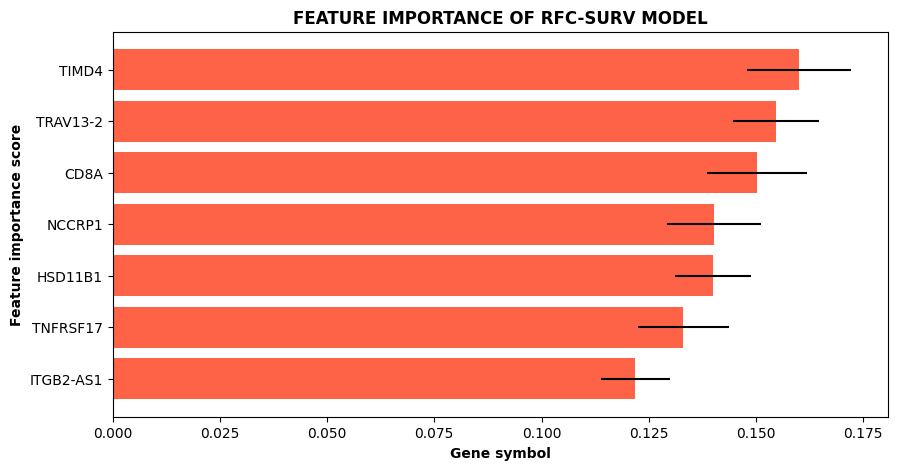

In [100]:
# TRỰC QUAN HÓA KẾT QUẢ FEATURE IMPORTANCE
utils.feature_importance_graph(df_feature_rfc_surv_final,'FEATURE IMPORTANCE OF RFC-SURV MODEL')

## 8.2.RFC-SEQ

In [20]:
def gene_filtered_dataframe(df:pd.DataFrame,dict_seleceted_gene:dict)->pd.DataFrame:
    list_gene_in_df=df.columns
    # TRƯỜNG HỢP DATAFRAME CÓ CỘT LÀ GENE ID: DIGIT
    if all(list(map(lambda x:x.isdigit(),list_gene_in_df))):
        df=df.loc[::,df.columns.isin(dict_seleceted_gene.keys())]
        df.rename(columns=dict_seleceted_gene,inplace=True)
    # TRƯỜNG HỢP DATAFRAME CÓ CỘT LÀ GENE SYMBOL
    else:
        df=df.loc[::,df.columns.isin(dict_seleceted_gene.values())]
    return df

#### 8.2.1.CHUẨN BỊ DỮ LIỆU 

In [103]:
dict_up_and_down_genes=utils.gene_dict_id_symbol(top_4_down+top_4_up)
dict_up_and_down_genes

Input sequence provided is already in string format. No operation performed


{'100505746': 'ITGB2-AS1',
 '574028': 'CLLU1',
 '654817': 'NCF1C',
 '9288': 'TAAR3P',
 '353133': 'LCE1C',
 '444882': 'IGFL4',
 '56146': 'PCDHA2',
 '8988': 'HSPB3'}

In [104]:
# LỌC TOP 8 GENE BỘ DỮ LIỆU GSE78220
df_gse78220_rfc_seq=df_gse78220_normalized.loc[::,df_gse78220_normalized.columns.isin(dict_up_and_down_genes.values())]
df_gse78220_rfc_seq

,CLLU1,HSPB3,IGFL4,ITGB2-AS1,LCE1C,NCF1C,PCDHA2
Pt1.baseline,0.031134,0.000000,1.926175,1.324825,0.000000,2.227675,1.721915e-02
Pt10.baseline,0.023754,0.146611,0.240910,0.322398,0.000000,2.016740,2.554450e-02
Pt12.baseline,0.016320,0.000000,6.661575,0.185412,0.043712,0.558847,3.163405e-44
Pt13.baseline,0.009076,0.000000,0.565820,1.090100,0.000000,5.745260,5.728740e-02
Pt14.baseline,0.017398,0.055231,0.063708,1.051490,0.028750,3.263695,9.105350e-03
Pt15.baseline,0.017010,2.058855,0.790077,1.823070,0.000000,4.330925,2.776550e-01
Pt16.OnTx,0.041516,0.000000,0.000000,0.322519,0.000000,7.717720,2.386900e-31
Pt19.baseline,0.121219,5.411515,0.119415,0.506889,0.000000,8.108240,1.794970e-23
Pt2.baseline,0.000000,0.046564,0.668588,0.818914,0.000000,4.809975,7.592816e-23
Pt20.baseline,0.012530,0.050482,0.000000,4.971495,0.000000,25.811550,1.233295e+00


In [105]:
# LỌC TOP 8 GENE BỘ DỮ LIỆU GSE91061
df_gse91061_normalized_rfc_seq=df_gse91061_normalized.loc[::,df_gse91061_normalized.columns.isin(dict_up_and_down_genes.keys())]
# ĐỔI TÊN GENE ID THÀNH GENE SYMBOL
df_gse91061_normalized_rfc_seq.rename(columns=dict_up_and_down_genes,inplace=True)
df_gse91061_normalized_rfc_seq

,ITGB2-AS1,LCE1C,IGFL4,PCDHA2,CLLU1,NCF1C,HSPB3,TAAR3P
Pt101_On_AD681975-5,9.725053,-1.444638,1.902541,1.035786,8.419779,10.030411,0.215859,-0.719818
Pt101_Pre_AD486328-5,9.244326,-1.311949,0.330398,1.063072,8.789311,11.536380,0.252421,-0.705124
Pt103_On_AE134059-6,5.532511,9.028036,2.373624,1.872334,3.617541,7.022998,1.854873,0.272620
Pt103_Pre_AE134058-2,9.005670,8.767246,0.496285,3.924143,5.441278,9.749929,4.172758,-0.649201
Pt105_On_AE373241-6,6.210693,-1.319089,0.327733,1.061530,4.096715,7.711705,0.250375,7.653572
...,...,...,...,...,...,...,...,...
Pt94_Pre_AD732850-6,6.292089,-1.117803,0.406390,1.108352,4.282924,7.255980,0.311374,-0.680844
Pt98_On_AE086717-6,5.643992,-1.256759,0.351318,4.907566,0.911832,7.659717,3.884349,-0.698559
Pt98_Pre_AD733586-8,4.690230,-1.215408,0.367352,4.594762,2.298259,7.143329,4.772450,-0.693464
Pt9_On_E9047644-7,4.860693,-1.420400,3.452616,4.996088,2.776997,7.029241,8.120946,-0.717248


In [106]:
# KÊT HỢP 2 BỘ DATA GSE78220 VÀ GSE91061
X_rfc_seq=pd.concat([df_gse78220_rfc_seq,df_gse91061_normalized_rfc_seq],axis=0)
X_rfc_seq

,CLLU1,HSPB3,IGFL4,ITGB2-AS1,LCE1C,NCF1C,PCDHA2,TAAR3P
Pt1.baseline,0.031134,0.000000,1.926175,1.324825,0.000000,2.227675,1.721915e-02,NaN
Pt10.baseline,0.023754,0.146611,0.240910,0.322398,0.000000,2.016740,2.554450e-02,NaN
Pt12.baseline,0.016320,0.000000,6.661575,0.185412,0.043712,0.558847,3.163405e-44,NaN
Pt13.baseline,0.009076,0.000000,0.565820,1.090100,0.000000,5.745260,5.728740e-02,NaN
Pt14.baseline,0.017398,0.055231,0.063708,1.051490,0.028750,3.263695,9.105350e-03,NaN
...,...,...,...,...,...,...,...,...
Pt94_Pre_AD732850-6,4.282924,0.311374,0.406390,6.292089,-1.117803,7.255980,1.108352e+00,-0.680844
Pt98_On_AE086717-6,0.911832,3.884349,0.351318,5.643992,-1.256759,7.659717,4.907566e+00,-0.698559
Pt98_Pre_AD733586-8,2.298259,4.772450,0.367352,4.690230,-1.215408,7.143329,4.594762e+00,-0.693464
Pt9_On_E9047644-7,2.776997,8.120946,3.452616,4.860693,-1.420400,7.029241,4.996088e+00,-0.717248


In [107]:
y_rfc_seq=pd.concat([df_meta_GSE78220['New_conditions_encoded'],df_meta_GSE91061['New_conditions_encoded']])
y_rfc_seq

Pt1                    0
Pt10                   0
Pt12                   0
Pt13                   1
Pt14                   0
                      ..
Pt94_Pre_AD732850-6    0
Pt98_On_AE086717-6     1
Pt98_Pre_AD733586-8    1
Pt9_On_E9047644-7      1
Pt9_Pre_E9021024-6     1
Name: New_conditions_encoded, Length: 133, dtype: int64

In [108]:
# CHIA TẬP TRAINING VÀ TESTING
X_train_rfc_seq,X_test_rfc_seq,y_train_rfc_seq,y_test_rfc_seq=train_test_split(X_rfc_seq,
                                                                                   y_rfc_seq,
                                                                                   random_state=42,
                                                                                   train_size=0.8,
                                                                                   stratify=y_rfc_seq)

#### 8.2.2.TRAIN MÔ HÌNH

In [111]:
# CROSS VADIATION MÔ HÌNH RFC-SEQ
cross_validation_rfc_seq=utils.cross_validation_by_RFC(10,X_train_rfc_seq,y_train_rfc_seq,'accuracy',42)
cross_validation_rfc_seq

array([0.63636364, 0.90909091, 0.72727273, 0.72727273, 0.81818182,
       0.72727273, 0.8       , 0.9       , 0.7       , 0.7       ])

In [113]:
df_score_rfc_seq,df_feature_rfc_seq=utils.training_RFC(X_train_rfc_seq,y_train_rfc_seq,X_test_rfc_seq,y_test_rfc_seq,100)

In [118]:
# METRICS MÔ HÌNH RFC-SEQ
df_score_rfc_seq

,accuracy_test,accuracy_train,recall,precison,f1
0,0.814815,1.0,0.80,0.941176,0.864865
1,0.851852,1.0,0.85,0.944444,0.894737
2,0.814815,1.0,0.80,0.941176,0.864865
3,0.777778,1.0,0.75,0.937500,0.833333
4,0.851852,1.0,0.85,0.944444,0.894737
...,...,...,...,...,...
95,0.777778,1.0,0.75,0.937500,0.833333
96,0.814815,1.0,0.80,0.941176,0.864865
97,0.777778,1.0,0.80,0.888889,0.842105
98,0.814815,1.0,0.80,0.941176,0.864865


In [117]:
# FEATURE IMPORTANCE MÔ HÌNH RFC-SEQ
df_feature_rfc_seq

,CLLU1,HSPB3,IGFL4,ITGB2-AS1,LCE1C,NCF1C,PCDHA2,TAAR3P
0,0.145532,0.093876,0.132891,0.095737,0.074022,0.121048,0.161787,0.175107
1,0.140310,0.096364,0.131632,0.103649,0.076789,0.142005,0.135102,0.174148
2,0.162963,0.104152,0.142132,0.085788,0.089513,0.116643,0.132880,0.165930
3,0.153363,0.111564,0.110478,0.093375,0.077516,0.143254,0.149109,0.161343
4,0.140665,0.099508,0.111595,0.088690,0.092815,0.152322,0.155602,0.158803
...,...,...,...,...,...,...,...,...
95,0.160628,0.097245,0.115773,0.090919,0.083513,0.129900,0.164076,0.157945
96,0.181472,0.090150,0.125091,0.106112,0.071430,0.130089,0.157674,0.137983
97,0.160809,0.095875,0.131100,0.093716,0.075742,0.120778,0.155069,0.166910
98,0.137525,0.090300,0.119263,0.093658,0.082336,0.143080,0.172452,0.161386


#### 8.2.3.KẾT QUẢ VÀ TRỰC QUAN HÓA

In [151]:
print(f'Kết quả cross-validation của mô hình RFC-SURV: {cross_validation_rfc_seq.mean():.4f}±{cross_validation_rfc_seq.std():.4f}')

Kết quả cross-validation của mô hình RFC-SURV: 0.7645±0.0850


In [124]:
#BẢN KẾT QUẢ METRICS
df_score_rfc_seq_final=utils.caculate_result(df_score_rfc_seq)
df_score_rfc_seq_final

,mean,std
accuracy_test,0.820370,0.035849
accuracy_train,1.000000,0.000000
recall,0.820500,0.044435
precison,0.929291,0.024148
f1,0.870758,0.027815


In [127]:
#BẢN KẾT QUẢ FEATURE IMPORANTANCE
df_feature_rfc_seq_final=utils.caculate_result(df_feature_rfc_seq)
df_feature_rfc_seq_final.sort_values(by='mean',inplace=True,ascending=True)
df_feature_rfc_seq_final

,mean,std
LCE1C,0.079113,0.006955
ITGB2-AS1,0.100751,0.008133
HSPB3,0.101770,0.008578
IGFL4,0.117374,0.009809
NCF1C,0.134043,0.010428
PCDHA2,0.152295,0.010845
TAAR3P,0.156363,0.010803
CLLU1,0.158292,0.010291


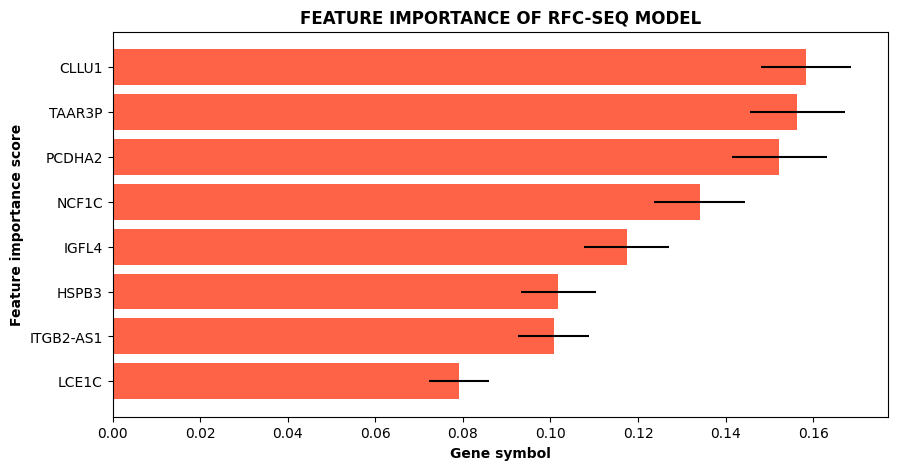

In [128]:
utils.feature_importance_graph(df_feature_rfc_seq_final,'FEATURE IMPORTANCE OF RFC-SEQ MODEL')

## 8.3.RFC-16

#### 8.3.1.CHUẨN BỊ DỮ LIỆU 

In [131]:
dict_gene_16=dict_up_and_down_genes.copy()
dict_gene_16.update(dict_top_8_gene)
dict_gene_16

{'100505746': 'ITGB2-AS1',
 '574028': 'CLLU1',
 '654817': 'NCF1C',
 '9288': 'TAAR3P',
 '353133': 'LCE1C',
 '444882': 'IGFL4',
 '56146': 'PCDHA2',
 '8988': 'HSPB3',
 '925': 'CD8A',
 '3290': 'HSD11B1',
 '342897': 'NCCRP1',
 '91937': 'TIMD4',
 '608': 'TNFRSF17',
 '28670': 'TRAV13-2'}

In [133]:
df_gse78220_rfc_16=utils.gene_filtered_dataframe(df_gse78220_normalized,dict_gene_16)
df_gse78220_rfc_16

,CD8A,CLLU1,HSD11B1,HSPB3,IGFL4,ITGB2-AS1,LCE1C,NCCRP1,NCF1C,PCDHA2,TIMD4,TNFRSF17
Pt1.baseline,7.000980,0.031134,3.871880,0.000000,1.926175,1.324825,0.000000,0.103352,2.227675,1.721915e-02,1.717475,1.229935
Pt10.baseline,0.852225,0.023754,2.524035,0.146611,0.240910,0.322398,0.000000,0.031969,2.016740,2.554450e-02,0.025166,0.000000
Pt12.baseline,0.424683,0.016320,5.329545,0.000000,6.661575,0.185412,0.043712,0.037742,0.558847,3.163405e-44,0.094384,0.027566
Pt13.baseline,25.246950,0.009076,4.797695,0.000000,0.565820,1.090100,0.000000,0.147132,5.745260,5.728740e-02,0.639527,0.291212
Pt14.baseline,3.674290,0.017398,2.946015,0.055231,0.063708,1.051490,0.028750,0.046271,3.263695,9.105350e-03,0.766837,0.042425
Pt15.baseline,10.995700,0.017010,0.508158,2.058855,0.790077,1.823070,0.000000,0.163296,4.330925,2.776550e-01,0.290699,1.527530
Pt16.OnTx,2.647070,0.041516,1.764710,0.000000,0.000000,0.322519,0.000000,1.634550,7.717720,2.386900e-31,0.000000,0.217395
Pt19.baseline,9.030915,0.121219,0.988278,5.411515,0.119415,0.506889,0.000000,0.150637,8.108240,1.794970e-23,0.249476,0.547161
Pt2.baseline,9.691270,0.000000,164.842000,0.046564,0.668588,0.818914,0.000000,0.067927,4.809975,7.592816e-23,5.431415,0.128545
Pt20.baseline,109.778500,0.012530,9.045125,0.050482,0.000000,4.971495,0.000000,0.765850,25.811550,1.233295e+00,0.357466,37.044300


In [134]:
df_gse91061_normalized_rfc_16=utils.gene_filtered_dataframe(df_gse91061_normalized,dict_gene_16)
df_gse91061_normalized_rfc_16

,ITGB2-AS1,TRAV13-2,HSD11B1,NCCRP1,LCE1C,IGFL4,PCDHA2,CLLU1,TNFRSF17,NCF1C,HSPB3,TIMD4,CD8A,TAAR3P
Pt101_On_AD681975-5,9.725053,5.822927,8.338059,5.413379,-1.444638,1.902541,1.035786,8.419779,8.603622,10.030411,0.215859,9.656047,11.377792,-0.719818
Pt101_Pre_AD486328-5,9.244326,6.017326,8.570024,6.458157,-1.311949,0.330398,1.063072,8.789311,8.769242,11.536380,0.252421,9.747960,11.328933,-0.705124
Pt103_On_AE134059-6,5.532511,2.755570,6.775924,8.549315,9.028036,2.373624,1.872334,3.617541,3.483469,7.022998,1.854873,2.726851,7.635343,0.272620
Pt103_Pre_AE134058-2,9.005670,4.496137,8.497873,9.214753,8.767246,0.496285,3.924143,5.441278,8.163234,9.749929,4.172758,4.823249,10.936760,-0.649201
Pt105_On_AE373241-6,6.210693,4.786366,9.427359,4.073086,-1.319089,0.327733,1.061530,4.096715,5.968032,7.711705,0.250375,6.871137,11.907791,7.653572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pt94_Pre_AD732850-6,6.292089,3.587451,7.519322,4.302166,-1.117803,0.406390,1.108352,4.282924,5.946053,7.255980,0.311374,7.004949,9.424188,-0.680844
Pt98_On_AE086717-6,5.643992,4.476089,7.568341,6.066942,-1.256759,0.351318,4.907566,0.911832,4.448721,7.659717,3.884349,4.483002,10.164901,-0.698559
Pt98_Pre_AD733586-8,4.690230,1.731532,6.396133,5.924993,-1.215408,0.367352,4.594762,2.298259,4.122981,7.143329,4.772450,2.383578,7.526615,-0.693464
Pt9_On_E9047644-7,4.860693,1.255144,4.710765,3.461268,-1.420400,3.452616,4.996088,2.776997,1.715957,7.029241,8.120946,3.383643,8.367420,-0.717248


In [136]:
X_rfc_16=pd.concat([df_gse78220_rfc_16,df_gse91061_normalized_rfc_16])
X_rfc_16

,CD8A,CLLU1,HSD11B1,HSPB3,IGFL4,ITGB2-AS1,LCE1C,NCCRP1,NCF1C,PCDHA2,TIMD4,TNFRSF17,TRAV13-2,TAAR3P
Pt1.baseline,7.000980,0.031134,3.871880,0.000000,1.926175,1.324825,0.000000,0.103352,2.227675,1.721915e-02,1.717475,1.229935,NaN,NaN
Pt10.baseline,0.852225,0.023754,2.524035,0.146611,0.240910,0.322398,0.000000,0.031969,2.016740,2.554450e-02,0.025166,0.000000,NaN,NaN
Pt12.baseline,0.424683,0.016320,5.329545,0.000000,6.661575,0.185412,0.043712,0.037742,0.558847,3.163405e-44,0.094384,0.027566,NaN,NaN
Pt13.baseline,25.246950,0.009076,4.797695,0.000000,0.565820,1.090100,0.000000,0.147132,5.745260,5.728740e-02,0.639527,0.291212,NaN,NaN
Pt14.baseline,3.674290,0.017398,2.946015,0.055231,0.063708,1.051490,0.028750,0.046271,3.263695,9.105350e-03,0.766837,0.042425,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pt94_Pre_AD732850-6,9.424188,4.282924,7.519322,0.311374,0.406390,6.292089,-1.117803,4.302166,7.255980,1.108352e+00,7.004949,5.946053,3.587451,-0.680844
Pt98_On_AE086717-6,10.164901,0.911832,7.568341,3.884349,0.351318,5.643992,-1.256759,6.066942,7.659717,4.907566e+00,4.483002,4.448721,4.476089,-0.698559
Pt98_Pre_AD733586-8,7.526615,2.298259,6.396133,4.772450,0.367352,4.690230,-1.215408,5.924993,7.143329,4.594762e+00,2.383578,4.122981,1.731532,-0.693464
Pt9_On_E9047644-7,8.367420,2.776997,4.710765,8.120946,3.452616,4.860693,-1.420400,3.461268,7.029241,4.996088e+00,3.383643,1.715957,1.255144,-0.717248


In [139]:
y_rfc_16=pd.concat([df_meta_GSE78220['New_conditions_encoded'],df_meta_GSE91061['New_conditions_encoded']])
y_rfc_16

Pt1                    0
Pt10                   0
Pt12                   0
Pt13                   1
Pt14                   0
                      ..
Pt94_Pre_AD732850-6    0
Pt98_On_AE086717-6     1
Pt98_Pre_AD733586-8    1
Pt9_On_E9047644-7      1
Pt9_Pre_E9021024-6     1
Name: New_conditions_encoded, Length: 133, dtype: int64

In [141]:
X_train_rfc_16,X_test_rfc_16,y_train_rfc_16,y_test_rfc_16=train_test_split(X_rfc_16,
                                                                           y_rfc_16,
                                                                           random_state=42,
                                                                           stratify=y_rfc_16,
                                                                           train_size=0.8)

#### 8.3.2.TRAIN MÔ HÌNH

In [143]:
cross_validation_rfc_16=utils.cross_validation_by_RFC(10,X_train_rfc_16,y_train_rfc_16,'accuracy',seed=42)
cross_validation_rfc_16

array([0.63636364, 0.90909091, 0.72727273, 0.72727273, 0.81818182,
       0.72727273, 0.8       , 0.9       , 0.5       , 0.6       ])

In [144]:
df_score_rfc_16,df_feature_rfc_16=utils.training_RFC(X_train_rfc_16,y_train_rfc_16,X_test_rfc_16,y_test_rfc_16,100)

#### 8.3.3.KẾT QUẢ VÀ TRỰC QUAN HÓA

In [150]:
print(f'Kết quả cross-validation của mô hình RFC-SURV: {cross_validation_rfc_16.mean():.4f}±{cross_validation_rfc_16.std():.4f}')

Kết quả cross-validation của mô hình RFC-SURV: 0.7345±0.1233


In [146]:
df_score_rfc_16_final=utils.caculate_result(df_score_rfc_16)
df_score_rfc_16_final

,mean,std
accuracy_test,0.842593,0.022566
accuracy_train,1.000000,0.000000
recall,0.840000,0.024618
precison,0.941244,0.013615
f1,0.887573,0.016936


In [148]:
df_feature_rfc_16_final=utils.caculate_result(df_feature_rfc_16)
df_feature_rfc_16_final.sort_values(by='mean',inplace=True,ascending=True)
df_feature_rfc_16_final

,mean,std
LCE1C,0.037461,0.005263
ITGB2-AS1,0.053929,0.006831
HSPB3,0.058328,0.006826
IGFL4,0.064565,0.007617
NCCRP1,0.064848,0.007410
TNFRSF17,0.064937,0.007459
NCF1C,0.068429,0.007404
CD8A,0.072012,0.008889
HSD11B1,0.072301,0.007276
TRAV13-2,0.079279,0.008861


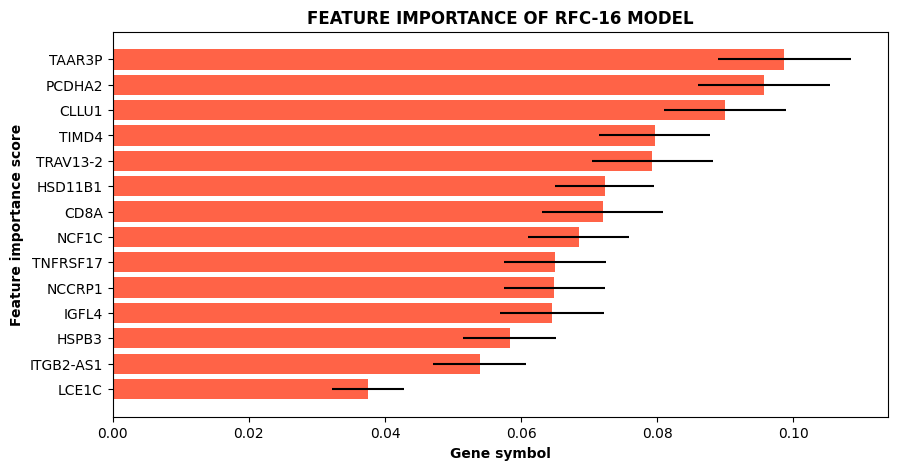

In [149]:
utils.feature_importance_graph(df_feature_rfc_16_final,'FEATURE IMPORTANCE OF RFC-16 MODEL')